Based on tensorflow starter code from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
#%pip install pydub
#%pip install keras_tqdm
#%pip install tensorflow-addons
#%pip install tensorflow-io
#%pip install pandas


In [1]:

#import array 
#from sklearn.utils import shuffle

import tensorflow as tf

import tensorflow.keras as keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate, LocallyConnected1D
from keras.layers import Activation, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool2D
from keras.layers import Dense, Dropout, Reshape, LSTM, Layer, LayerNormalization, InputLayer, Permute, GRU, Cropping1D
from keras.layers import TimeDistributed, Conv2DTranspose, UpSampling2D, MultiHeadAttention, Embedding, Rescaling, Masking
from keras.layers import ZeroPadding1D, ZeroPadding2D, GaussianNoise, DepthwiseConv2D, Cropping2D, RepeatVector, RNN
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, AveragePooling2D
from keras.regularizers import l1, l2
from keras import activations, losses
from keras.constraints import max_norm

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import LAMB 
import tensorflow_io as tfio

from keras import optimizers
from keras.losses import CategoricalCrossentropy
import numpy as np

import re
import os

import pandas as pd
from tensorflow.keras.utils import to_categorical


from random import *
import math

#import tqdm as tqdm
#from tqdm.notebook import tqdm, trange

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import keras.backend as K
import matplotlib.pyplot as plt

import gc as gc


%matplotlib inline

projDir = ''


#model_dtype = "float32"


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.set_visible_devices([], 'GPU')       # uncomment to run on CPU

DEVICE = "/device:CPU:0"
print("Done")




d:\Apps\Anaconda\envs\TF_GPU\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1889887532369409952
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7365364736
locality {
  bus_id: 1
}
incarnation: 13581922115692905123
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]
Done


In [2]:
# index dataset

#POSSIBLE_LABELS = 'bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero unknown'.split()
#POSSIBLE_LABELS = 'yes no up down left right on off stop go zero one two three four five six seven eight nine unknown'.split()      # 20 + unknown

POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown'.split()      # 10 + unknown





id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(POSSIBLE_LABELS)



11

In [3]:
#load dataset


trainX = np.load("specs_train.npy")
trainY = np.load("results_train.npy")
trainX = tf.convert_to_tensor(trainX, dtype=tf.float32) / 255.0

valX = np.load("specs_val.npy")
valY = np.load("results_val.npy")
valX = tf.convert_to_tensor(valX, dtype=tf.float32) / 255.0

print('There are {} train and {} validation (including background noise)'.format(trainX.shape[0], valX.shape[0]))



There are 52736 train and 7040 validation (including background noise)


In [5]:
#np.bincount(valY)


print(valY.shape, np.sum(valY, axis=0))



(7040, 11) [ 261.  270.  260.  264.  247.  255.  257.  256.  246.  258. 4466.]


In [4]:
from keras.callbacks import TensorBoard
exp_name = "test_MAE_large_test"


callbacks = [TerminateOnNaN()]



In [5]:
# Architecture

with tf.device(DEVICE):

    K.clear_session()   
    


    class TransformerBlock(Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.05):
            super(TransformerBlock, self).__init__()

            self.num_heads = num_heads
            self.embed_dim = embed_dim
            self.ff_dim = ff_dim
            self.dropout_rate = rate

            self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, 
                                          kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))
            self.ffn = Sequential(
                [Dense(ff_dim, activation="ReLU", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),        # LeakyReLU
                 Dense(embed_dim, kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),]
            )
            self.layernorm1 = LayerNormalization(epsilon=1e-6)
            self.layernorm2 = LayerNormalization(epsilon=1e-6)
            self.dropout1 = Dropout(rate)
            self.dropout2 = Dropout(rate)

        @tf.function(jit_compile=False, experimental_follow_type_hints=True)
        def call(self, inputs, training=True):
            attn_output = self.att(inputs, inputs)
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1(inputs + attn_output) # layernorm
            ffn_output = self.ffn(out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            return self.layernorm2(out1 + ffn_output)       # layernorm2


        def get_config(self):
            cfg = super(TransformerBlock, self).get_config()
            cfg.update({'num_heads': self.num_heads,
                        'embed_dim': self.embed_dim,
                        'ff_dim': self.ff_dim,
                          'dropout_rate': self.dropout_rate})
            return cfg



    
    
    class RandomMask(Layer):
        def __init__(self, maxLen=64, masked_rate=0.75):
            super(RandomMask, self).__init__()

            self.maskedRate = masked_rate
            self.maxLen = maxLen
            self.trainable = False
 
        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            batch_size = tf.shape(inputs)[-3]   # or 0 ?
            mask = tf.random.uniform(shape=(batch_size, self.maxLen,), minval=0.0, maxval=1.0, dtype=tf.float32)      # stateless_uniform
            mask = tf.cast(tf.math.greater(mask, self.maskedRate), dtype=tf.float32) 
            
            mask = tf.expand_dims(mask, axis=-1)
            mask = tf.tile(mask, multiples=(1, 1, tf.shape(inputs)[-1]))        # expand the last dimension
            
            #if training: 
            return tf.math.multiply(inputs, mask), mask
            
            #return inputs, tf.ones(tf.shape(inputs))        # ones = no mask


        def get_config(self):
            cfg = super(RandomMask, self).get_config()
            cfg.update({'maskedRate': self.maskedRate,
                        'maxLen': self.maxLen})
            return cfg
        
    
    class RestoreUnmaskedTokens(Layer):
        def __init__(self, maxLen=64):
            super(RestoreUnmaskedTokens, self).__init__()

            self.maxLen = maxLen
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            reconstructed, original, mask = inputs
            
            rec = tf.math.multiply(reconstructed, 1.0 - mask)
            remain = tf.math.multiply(original, mask)
            
            #if training: 
            return rec + remain
            
            #return reconstructed


        def get_config(self):
            cfg = super(RestoreUnmaskedTokens, self).get_config()
            cfg.update({'maxLen': self.maxLen})
            return cfg
        
        


    


    class PositionEmbedding(Layer):
        def __init__(self, maxlen, embed_dim):
            super(PositionEmbedding, self).__init__()
            self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
            self.maxlen = maxlen

        @tf.function(jit_compile=False)
        def call(self, x):
            #maxlen = tf.shape(x)[-1]
            positions = tf.range(start=0, limit=self.maxlen, delta=1)
            positions = self.pos_emb(positions)
            return x + positions

        def get_config(self):
            cfg = super(PositionEmbedding, self).get_config()
            cfg.update({'pos_emb': self.pos_emb,
                        'maxlen': self.maxlen})
            return cfg

    
    
    
    
    class RandomNoise(Layer):
        def __init__(self, max_amp=0.1):
            super(RandomNoise, self).__init__()
            self.max_amp = max_amp
            self.trainable = False
            

        @tf.function(jit_compile=False)
        def call(self, x, training=None):
            inp_shape = tf.shape(x)
            batch_size = inp_shape[0]
            
            if not training:
                return x
            
            amp = tf.random.uniform([batch_size], minval=0.0, maxval=1.0, dtype=tf.float32) * self.max_amp  
            noise = tf.random.normal(shape=inp_shape, mean=0.0, stddev=1.0, dtype=tf.float32)
            
            amp = tf.reshape(amp, shape=[batch_size, 1, 1])
            amp = tf.tile(amp, multiples=(1, inp_shape[-2], inp_shape[-1]))        # expand the last dimension
            
            return x + noise * amp


        def get_config(self):
            cfg = super(RandomNoise, self).get_config()
            cfg.update({'max_amp': self.max_amp})
            return cfg



    
    class AugmentAmplitude(Layer):
        def __init__(self, mean_aug=0.1, percent_aug=0.1):
            super(AugmentAmplitude, self).__init__()
            self.mean_aug = mean_aug
            self.percent_aug = percent_aug
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, x, training=None):

            inp_shape = tf.shape(x)
            batch_size = inp_shape[0]
            
            if not training:
                return x
            
            mean_shift = tf.random.uniform([batch_size], minval=-1.0, maxval=1.0, dtype=tf.float32) * self.mean_aug    
            # for mean_aug=0.1   -   (-0.1, 0.1)
            
            relative_change = tf.random.uniform([batch_size], minval=1.0-self.percent_aug, maxval=1.0+self.percent_aug, dtype=tf.float32)  
            # for 0.1 relative augmentation, get random on (0.9, 1.1)

    
            relative_change = tf.reshape(relative_change, shape=[batch_size, 1, 1])
            mean_shift = tf.reshape(mean_shift, shape=[batch_size, 1, 1])
            
            relative_change = tf.tile(relative_change, multiples=(1, inp_shape[-2], inp_shape[-1]))        # expand the last dimension
            mean_shift = tf.tile(mean_shift, multiples=(1, inp_shape[-2], inp_shape[-1])) 
            
            
            return x * relative_change + mean_shift 


        def get_config(self):
            cfg = super(AugmentAmplitude, self).get_config()
            cfg.update({'mean_aug': self.mean_aug, 
                        'percent_aug': self.percent_aug})
            return cfg
        
        
    




        
    class ClampLayer(Layer):
        def __init__(self, lower_bound=0.0, upper_bound=1.0):
            super(ClampLayer, self).__init__()
            self.lower = lower_bound
            self.upper = upper_bound
            self.trainable = False


        @tf.function(jit_compile=False)
        def call(self, x : tf.Tensor) -> tf.Tensor:
            return tf.clip_by_value(x, self.lower, self.upper)
        

        def get_config(self):
            cfg = super(ClampLayer, self).get_config()
            cfg.update({'lower': self.lower, 
                        'upper': self.upper})
            return cfg
        
        

    




In [8]:

################################ Full masked AE



timesteps = 90
mel_bins = 60
embed_dim = 128



inp = Input(shape=[timesteps, mel_bins])      # Input = right from STFT

x = inp

before_mask = x
x, mask = RandomMask(maxLen=timesteps, masked_rate=0.75)(before_mask)

x = AugmentAmplitude(mean_aug=0.00, percent_aug=0.00)(x) 
x = RandomNoise(0.00)(x)
x = ClampLayer(lower_bound=0.0, upper_bound=1.0)(x)





x = Dense(256, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = Dense(128, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = PositionEmbedding(timesteps, 128)(x)
x = Dense(embed_dim, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


# Encoder
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)

x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)




# Decoder
x = Dense(256, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = PositionEmbedding(timesteps, 256)(x)
x = Dense(embed_dim, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)


x = Dense(256, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = Dense(128, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


x = Dense(mel_bins, activation = 'linear', name='targets')(x)

x = RestoreUnmaskedTokens(maxLen=timesteps)([x, before_mask, mask])

outp = x






model = Model(inp, outp, name="model")
opt = LAMB(learning_rate=0.001)


model.compile(optimizer=opt, loss="MSE")  
model.build(input_shape=[timesteps, mel_bins])

model.load_weights("weights/test_transformer_MAE_large")

model.summary()

gc.collect()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 90, 60)]     0           []                               
                                                                                                  
 random_mask_2 (RandomMask)     ((None, 90, 60),     0           ['input_3[0][0]']                
                                 (None, 90, 60))                                                  
                                                                                                  
 augment_amplitude_2 (AugmentAm  (None, 90, 60)      0           ['random_mask_2[0][0]']          
 plitude)                                                                                         
                                                                                              

14951

In [24]:
# Linear probing




timesteps = 90
mel_bins = 60
embed_dim = 128



inp = Input(shape=[timesteps, mel_bins])    

x = inp

before_mask = x
x, mask = RandomMask(maxLen=timesteps, masked_rate=0.75)(before_mask)

x = AugmentAmplitude(mean_aug=0.05, percent_aug=0.05)(x) 
x = RandomNoise(0.05)(x)
x = ClampLayer(lower_bound=0.0, upper_bound=1.0)(x)





x = Dense(256, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = Dense(128, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = PositionEmbedding(timesteps, 128)(x)
x = Dense(embed_dim, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


# Encoder
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)

x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.1)(x)




# Decoder
x = Dense(256, activation = 'relu', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)

x = GlobalAveragePooling1D()(x)


outp = x






encoder = Model(inp, outp, name="encoder")
opt = LAMB(learning_rate=0.001)

encoder.build(input_shape=[timesteps, mel_bins])


encoder.load_weights("weights/test_transformer_MAE_large").expect_partial()


#for i in range(17):
#    encoder.layers[i].trainable = False
    
encoder.trainable = False
encoder.summary()




# Classifier

inp = Input(shape=[256])    

x = inp

#x = Dense(256, activation = 'ReLU')(x) # 


x = Dense(len(POSSIBLE_LABELS), activation = 'softmax', name='targets')(x)

outp = x






classifier = Model(inp, outp, name="classifier")
opt = LAMB(learning_rate=0.001)

#loss = CategoricalCrossentropy(label_smoothing=0.1)
#classifier.compile(optimizer=opt, loss=loss, metrics=['accuracy'])  
classifier.build(input_shape=[256])
classifier.summary()


# Merged model


inp = Input(shape=[timesteps, mel_bins])    

x = encoder(inp)
x = classifier(x)

outp = x






merged = Model(inp, outp, name="merged")
opt = LAMB(learning_rate=0.001)

loss = CategoricalCrossentropy(label_smoothing=0.1)
merged.compile(optimizer=opt, loss=loss, metrics=['accuracy'])  
merged.build(input_shape=[timesteps, mel_bins])
merged.summary()

gc.collect()



Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 90, 60)]          0         
                                                                 
 random_mask_11 (RandomMask)  ((None, 90, 60),         0         
                              (None, 90, 60))                    
                                                                 
 augment_amplitude_11 (Augme  (None, 90, 60)           0         
 ntAmplitude)                                                    
                                                                 
 random_noise_11 (RandomNois  (None, 90, 60)           0         
 e)                                                              
                                                                 
 clamp_layer_11 (ClampLayer)  (None, 90, 60)           0         
                                                           

18225

In [25]:
# train
gc.collect()

K.set_value(merged.optimizer.learning_rate, 0.001)
batch_size = 512


class_weights = np.sum(trainY) / (trainY.shape[1] * np.sum(trainY, axis=0))
class_weights = {i:w for i, w in enumerate(class_weights) }  # same as balanced from sklearn, n_samples / (n_classes * np.bincount(y)) 

print("Class weights:", class_weights)




try:

    hist = merged.fit(x=trainX, y=trainY, callbacks=callbacks, validation_data=(valX, valY), class_weight=class_weights,
                     batch_size = batch_size, epochs = 10)  # 
    
    #hist = SAM_model.fit(cur_dataset, validation_data=cur_val_dataset, callbacks=callbacks, class_weight=class_weights,
    #                 batch_size = batch_size, epochs = 100)  # 
    
    
    merged.save_weights("weights/" + exp_name + "_merged")
    encoder.save_weights("weights/" + exp_name + "_encoder")
    classifier.save_weights("weights/" + exp_name + "_classifier")
    
    fig = plt.figure(figsize=(10, 5))
    plt.plot(hist.history["loss"], color="blue")
    plt.plot(hist.history["val_loss"], color="red")
    plt.title("Loss curve")
    plt.legend(["Training loss", "Validation loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig("loss.png") # eps 
    
    #plt.show()
except KeyboardInterrupt:
    print("Interrupted")





#AE.fit(X, X, callbacks=callbacks, validation_data=(valX, valX), batch_size = 512, epochs = 100, shuffle=True)  #   validation_data=(valX, valY)
#model.fit(training_generator, callbacks=callbacks, validation_data=validation_generator, batch_size = batch_size, epochs = 7, use_multiprocessing = True, workers = 2)  # initial_epoch = 5


#model.save_weights(projDir + 'weights/test_2.hdf5')
#model.save(projDir + 'models/' + exp_name)

Class weights: {0: 2.581681, 1: 2.5956588, 2: 2.6083689, 3: 2.6069505, 4: 2.6126332, 5: 2.5984726, 6: 2.5747485, 7: 2.6169114, 8: 2.548741, 9: 2.5802915, 10: 0.1400088}
Epoch 1/10
  7/103 [=>............................] - ETA: 19:58 - loss: 3.2942 - accuracy: 0.0446Interrupted


In [31]:
encoder.save_weights("weights/" + exp_name + "_encoder")

#model.load_weights("teeeest")
#model.save_weights("teeeest")

1/1 [==============================] - 0s 202ms/step
(90,)


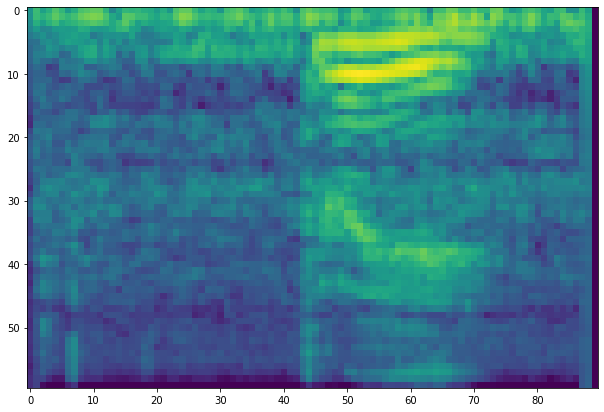

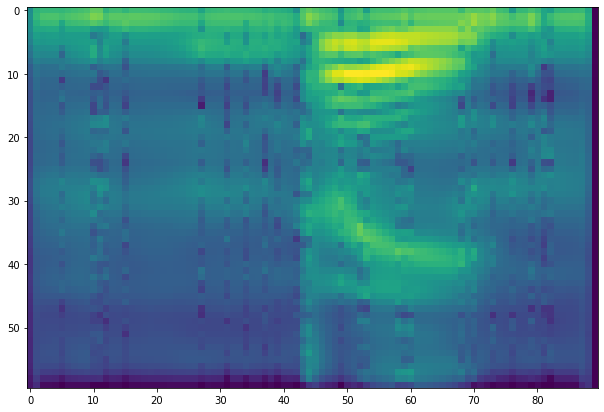

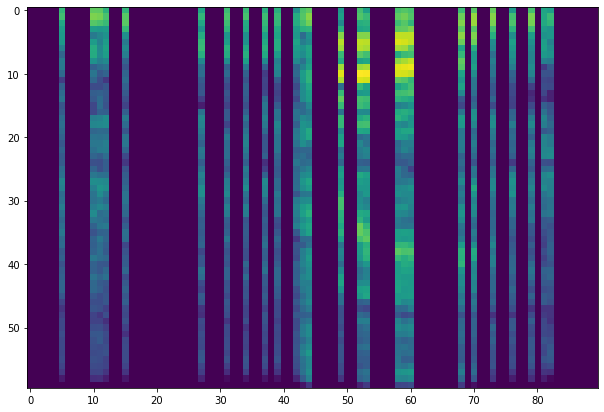

In [49]:




# Evaluate autoencoder

N = 16           # 9, 10    13


inp_x = tf.expand_dims(valX[N], axis=0)
outp_x = model.predict(inp_x)

outp_x = outp_x[0]



fig = plt.figure(figsize=(14, 7))
imgplot = plt.imshow(np.transpose(valX[N]), vmin=0.0, vmax=1.0)

fig = plt.figure(figsize=(14, 7))
imgplot = plt.imshow(np.transpose(outp_x), vmin=0.0, vmax=1.0)




masked = valX[N] - outp_x
maxLen = 90

mask = tf.reduce_max(masked, axis=-1)

print(mask.shape)


mask = tf.cast(tf.math.greater(mask, 0.0), dtype=tf.float32) 

mask = tf.expand_dims(mask, axis=-1)
mask = tf.tile(mask, multiples=(1, tf.shape(masked)[-1]))        # expand the last dimension

masked = tf.math.multiply(valX[N], 1.0 - mask)




fig = plt.figure(figsize=(14, 7))
imgplot = plt.imshow(np.transpose(masked), vmin=0.0, vmax=1.0)








In [ ]:
# Show layers output

"""

"""

layer_num = 2
enc = True





if enc:
    mdl = encoder
    inp = next(data_iter)[0]
else:
    mdl = decoder
    inp = encoded
       
layer_outputs = [layer.output for layer in mdl.layers[:]] 
generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_activations = Model(inputs=mdl.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(inp, axis=0))


print(activations[layer_num][0].shape)

x = activations[layer_num][0]
x = np.transpose(x, (2, 0, 1))
#print(x.shape)

print("Min, max: ", np.min(x), np.max(x))
#print("AE: ", x[0, :24, :24])





aspect_ratio = x.shape[1] / x.shape[2]  # 2.0 -> vyska = 2 * sirka
channel_count = x.shape[0]

x_count = 6 # charts per row
y_count = channel_count // x_count + 1



fig = plt.figure(figsize=(24, int(24 * aspect_ratio * y_count / x_count)))

for i, xr in enumerate(x):

    fig.add_subplot(y_count, x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')

print("Done")








NameError: name 'encoder' is not defined

In [ ]:
# Show output interval

print("### ENCODER ###")
   
layer_outputs = [layer.output for layer in model.layers[:]] 

generate = True
if generate:
    get_activations = Model(inputs=model.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(next(data_iter)[0][0], axis=0))
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(model.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')










### ENCODER ###
         Min      Max       SqrtVar   
Layer 0 input_2 [(None, 32, 128)]
   -1.4901161e-08 1.0 0.17397629 

Layer 1 gru_1 (None, 64)
   -0.8016856 0.8713495 0.43068796 

Layer 2 dense_1 (None, 64)
   -0.926757 0.91028786 0.55776656 

Layer 3 targets (None, 30)
   0.001242202 0.36259094 0.073918976 



In [ ]:
## show kernels


mdl = encoder
inp = X[0]   #encoded
layer_weights = [layer.weights for layer in mdl.layers[:]] 

generate = True
if generate:
    #for i, l in enumerate(mdl.layers):
    #    print(i, l.name, l.output_shape)

    get_weights_model = Model(inputs=mdl.input, outputs=layer_weights)
    weights = get_weights_model.predict(np.expand_dims(inp, axis=0))

layer_num = 4

weights = layer_weights[2]
print(weights)



#print(weights[layer_num].shape)

x = np.array(weights)[0]
x = np.transpose(x, (2, 0, 1, 3))[0]
x = np.transpose(x, (2, 1, 0))   # transpose



aspect_ratio = 64 / 64

x_count = 4
y_size = 32 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    fig.add_subplot(x.shape[0], x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')
    


print("Done")





In [ ]:
result = AE.predict(X[:2])[0]

difference = X[0]-result

print("AE: ", np.min(X[0]), np.max(X[0]))
print("AE: ", np.min(result), np.max(result))
print("Diff: ", np.min(difference), np.max(difference))

aspect_ratio = 256 / 64
y_size = 32

fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))
plt.imshow(difference, cmap='gray')
plt.axis('off')

print("Done")


NameError: name 'AE' is not defined

Done


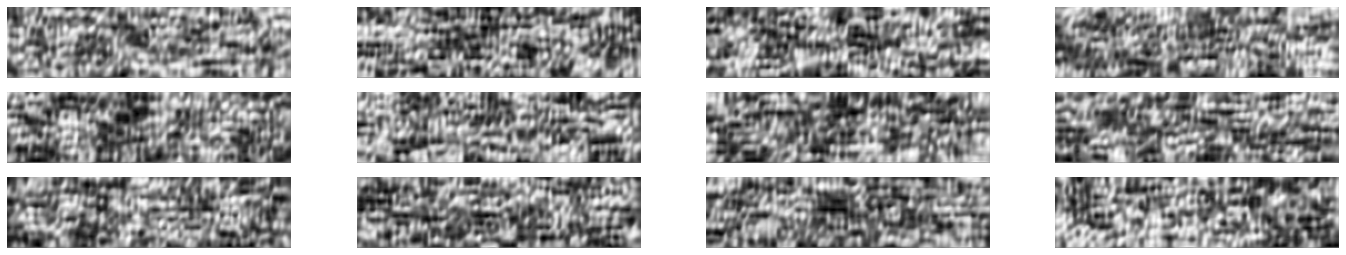

In [ ]:
# Sample decoder



N = 12
enc = tf.random.normal([N, 4, 256], dtype=tf.float16) * 1.0
x = trans_block2(enc)

#tf.print(x)

x = decoder(x)


aspect_ratio = x.shape[1] / x.shape[2]  # 2.0 -> vyska = 2 * sirka
channel_count = x.shape[0]

x_count = 4 # charts per row
y_count = channel_count // x_count + 1



fig = plt.figure(figsize=(24, int(24 * aspect_ratio * y_count / x_count)))

for i, xr in enumerate(x):

    fig.add_subplot(y_count, x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')

print("Done")








In [ ]:

class RandomMask2(Layer):
    def __init__(self, maxLen=64, masked_rate=0.75, blur_kernel = 3):
        super(RandomMask2, self).__init__()

        self.maskedRate = masked_rate
        self.maskLayer = Masking(mask_value=0.0)
        self.rnd = tf.random.get_global_generator()
        self.maxLen = maxLen
        self.blur_kernel = blur_kernel
        self.trainable = False
       

    def call(self, inputs):

        input_dims = [tf.shape(inputs)[-1], tf.shape(inputs)[-2]] # transposed
        mask = self.rnd.uniform(shape=(self.maxLen,), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
        mask = tf.math.greater(mask, self.maskedRate)
        mask = tf.cast(mask, tf.dtypes.float32)
        
        mask = tf.transpose(tf.ones(input_dims) * mask)
        
        blured = tfa.image.mean_filter2d(inputs, filter_shape = (1, self.blur_kernel))

        return inputs * mask + blured * (1.0 - mask)


    def get_config(self):
        cfg = super(RandomMask2, self).get_config()
        cfg.update({'maskedRate': self.maskedRate,
                    'blur_kernel': self.blur_kernel,
        	        'maxLen': self.maxLen})
        return cfg




x = X[2]

#rand_mask = RandomMask2(256, 0.75, 1)

sPool = TempPoolingBlock(128, num_heads=36, ff_dim=1024)

x = tf.expand_dims(x, axis=0)

x = sPool(x)[0]



#loss_result = FFT_patch_loss(X[0:4], X[5:9])
#print(loss_result.shape)




fig = plt.figure(figsize=(12, 20))
plt.imshow(x, cmap='gray')
plt.axis('off')


NameError: name 'X' is not defined

In [ ]:
# Clear memory

err = 0.07          # losses  1.22 -> 1.17

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + tf.abs(err)) * 100 )     
    
print("\n\n\n")

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + 100 * tf.abs(err)) * 10 ) 
    
    # tf.math.reduce_mean(tf.math.log(1.0 + 100 * tf.abs(spec1-spec2))) * 10 


#loss = 4.59
#print("Error: ", tf.math.exp(loss / 100.0) - 1)

#del X, Y
#gc.collect()

# %debug          commands -     h

#model.load_weights(projDir + 'models/' + "working_CNN_AE")

#print(tmps[0])
#with open(projDir + 'data/train_X_hartley.npy', 'wb') as f:
#  np.save(f, X)

#with open(projDir + 'data/valid_X_hartley.npy', 'wb') as f:
#  np.save(f, valX)

In [ ]:
import pyaudio
import wave
import numpy as np

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 1
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    np_data = np.frombuffer(data, dtype=np.int16)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

In [ ]:
# Generator class


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, filename, batch_size = 32, shuffle = True):
        'Initialization'

        self.batch_size = batch_size

        self.allX = np.load(projDir + "data/" + filename + "_X.npy")
        self.allY = np.load(projDir + "data/" + filename + "_Y.npy")

        self.size = self.allX.shape[0]

        self.indexes = np.arange(self.size)
        self.shuffle = shuffle
        self.on_epoch_end()



    def __len__(self):
        'Denotes the number of batches per epoch'

        return int(np.floor(self.size / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)


    def on_epoch_end(self):
        'Updates indexes after each epoch'

        if self.shuffle == True:
            np.random.shuffle(self.indexes)



    def __data_generation(self, IDs):


        # Initialization
        #tmpX = np.diff(np.array(self.allX)[IDs], axis=-2, prepend=0) 

        tmpX = np.array(self.allX)[IDs]
        tmpY = np.array(self.allY)[IDs]

        #for ID in range(tmpX.shape[0]): 
        #  tmpX[ID] = augment_spectrogram_diff(tmpX[ID])
          # dalse augmentace


        return tmpX, tmpY


training_generator = DataGenerator("train", batch_size, shuffle=True)
validation_generator = DataGenerator("valid", batch_size, shuffle=False)

In [ ]:
# Load model


model = load_model(projDir + 'models/' + exp_name)
print('Loaded')

In [ ]:
# save model
exp_name = "64x256_4x16x16_AE"
test_m.save_weights(projDir + 'weights/' + exp_name + '.hdf5')
test_m.save(projDir + 'models/' + exp_name)

encoder.save_weights(projDir + 'weights/encoder_' + exp_name + '.hdf5')
encoder.save(projDir + 'models/encoder_' + exp_name)

decoder.save_weights(projDir + 'weights/decoder_' + exp_name + '.hdf5')
decoder.save(projDir + 'models/decoder_' + exp_name)

#styleLayer.save_weights(projDir + 'weights/styleLayer_' + exp_name + '.hdf5')
#styleLayer.save(projDir + 'models/styleLayer_' + exp_name)

#trans_block.save_weights(projDir + 'weights/trans_block_' + exp_name + '.hdf5')
#trans_block.save(projDir + 'models/trans_block_' + exp_name)

print('Saved')



INFO:tensorflow:Assets written to: models/64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/encoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/encoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/decoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/decoder_64x256_4x16x16_AE/assets


Saved


In [ ]:
# Evaluate random sample

random_index = randint(0, valid_df.shape[0])
fileName = valid_df.wav_file[random_index]

mel = np.transpose(process_wav_file(fileName))
mel = augment_spectrogram_diff(mel)


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play



In [ ]:
# Test

fileName = projDir + 'mySounds/go_1.wav'

mel = np.transpose(process_wav_file(fileName))

plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=0, vmax=80, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = augment_spectrogram_diff(mel)


plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=-26, vmax=26, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play


In [ ]:
# Evaluate accuracy for each keyword

#[valX, valY] = load_data_from_bin("DataAll_valid_128_64")

correctGuess = np.zeros(len(POSSIBLE_LABELS))
mistakeIDs = []

results = model.predict(valX)


ids = np.argmax(results, axis=1)
correctIDs = np.argmax(valY, axis=1)


#print(np.bincount(ids))
#print(np.bincount(correctIDs))


for i in range(len(valY)):
  if ids[i] == correctIDs[i]:
    correctGuess[ids[i]] = correctGuess[ids[i]] + 1
  else:
    mistakeIDs.append([i, ids[i], correctIDs[i]])

#print(correctGuess)
    
correctGuess = np.divide(correctGuess, np.bincount(correctIDs, minlength = len(POSSIBLE_LABELS)))



#correctGuess[30] = 0.0  # unknown zatim neni ve validation setu

print("\n")
print("Pravdepodobnost spravneho rozpoznani")
for i in range(len(correctGuess)):
  print(id2name[i], " %.2f" % (correctGuess[i] * 100), '%')

print("\n")
print("Stredni uspesnost: %.2f" % (sum(correctGuess) / len(correctGuess) * 100), '%')
print("\n")


random_index = randint(0, len(mistakeIDs))
fileName = valid_df.wav_file[mistakeIDs[random_index][0]]


with open("./mistakes.txt", "w") as f:
  for mID, g1, g2 in mistakeIDs:
    f.write(str(mID) +"\n")




In [ ]:
# show mistakes

random_index = randint(0, len(mistakeIDs))
fileName = valid_df.wav_file[mistakeIDs[random_index][0]]


with open(projDir + "/mistakes.txt", "w") as f:
  for mID, g1, g2 in mistakeIDs:
    f.write(str(mID) +"\n")



print(id2name[mistakeIDs[random_index][1]], id2name[mistakeIDs[random_index][2]])   # print prediction
AudioSegment.from_wav(fileName) # play
